# Planteamiento 

Encontrar los niveles de energía de la molecula $Mg_2$ utilizando la técnica descrita en el paper "Numerical implementation of Einstein-Brillouin-Keller quantization for arbitrary potentials". En resumen, debemos encontrar los valores de energía $E$, tales que 

$$ f(E) = \frac{\sqrt{2\mu}}{\pi}\int^{r_2}_{r_1}{ \sqrt{E - \left[\frac{a}{r^{12}} - \frac{b}{r^6} + (l^2 + l +\frac{1}{4})\frac{\hbar^2}{2\mu r^2}\right]}dr} - \left(n_r + \frac{1}{2}\right)h = 0$$

Para tal hazaña, hay que considerar los siguientes hechos:

* Los límites $r_1$ y $r_2$ no se conocen, pero se definen como los valores extremos para los cuales el potencial $V_r$ es igual a la energia $E$. Por tanto, debemos encontrar las raíces de la función $g(r)$ tal que

$$ g(r) = E-V_r = 0 $$

* Una vez logrando eso, tenemos los necesario para calcular la integral a través de cualquier algortimo numérico.
* A partir de aquí solo falta ajustar el valor de $E$ para que se cumpla la condición $f(E) = 0$.
* La labor descrita debe ser hecha para una combinación de valores $l$ y $n_r$ ya estipulados por el problema.

## Implementación

In [2]:
import numpy as np
from math import sqrt
from math import pi
import matplotlib.pyplot as plt
from decimal import *
%matplotlib inline

Considerando unidades atómicas y obteniendo del paper los parámetros a y b concluimos los siguientes datos.

In [3]:
masa_mg = 2*(1836*12) + 12
a,b = 4.96*(10**7),624
mu = masa_mg**2 / (2*masa_mg)
h = 1

Dónde:
* masa_mg: masa de un átomo de mg
* a,b: parámetros de la función de potencial $V_r$
* mu: masa reducida $\mu$
* h: constante de Planck 

La siguiente función cálcula el potencial $V_r$ con sus respectivos parámetros y dominio $r$,

In [4]:
def V_r(l,r):
    '''
    Regresa un vector o escalar de potencial evaluado en r.
    '''
    line = a/r**12 - b/r**6 + (((l**2 + l + .25)*h**2)/(2*mu*r**2))
    return line                

Ahora bien, el problema nos pide tener a la mano un algortimo para aproximar integrales. En el paper, los autores mecionan que su elección fue la técnica de simpson. El código para tal se muestra a continuación.

In [5]:
def simpson38(y,a,b,n):
    '''
    n: Número de segmentos.Debe ser un múltiplo de 3.
    Nota: el vector 'y' debe tener un dominio de longitud n+1.
    ''' 
    h = (b-a)/n
    s0 = y[0]
    s1 = sum(y[1:n-1:3])
    s2 = sum(y[2:n:3])
    s3 = sum(y[3:n-2:3])
    s4 = y[n]
    aprox_result = (3*h/8)*(s0 + 3*s1 + 3*s2 + 2*s3 + s4)
    return aprox_result

De manera similar, necesitamos un algoritmo para búsqueda de raíces. Decidimos, al igual que los autores, utilizar Newthon-Raphson. Sin embargo, para esto, necesitamos la derivdad de la función cuyas raíces se quieren encontrar, en este caso es la anteriormente definida $g(r)$. La derivada de $g(r)$ viene dada por

$$ \frac{dg}{dr} = \frac{12a}{r^{13}} - \frac{6b}{r^7} + \frac{\hbar^2(l^2+l+\frac{1}{4})}{\mu r^3} $$

El código para $g(r)$, $\frac{dg}{dr}$ y N-R están en la siguiente celda

In [6]:
def g(l,E,r):
    return E- V_r(l,r)

def der_g(l,r):
    der = (12*a/r**13) - 6*b/r**7 + ((h**2*(l**2 + l + .25)) / (mu*r**3))
    return der

def NR(guess, l, E, tol):
    while np.abs(g(l,E, guess)) > tol:
        guess = guess - g(l,E, guess)/der_g(l, guess)
    return guess 

Como ejemplo, a continuación se muestra una evidencia gráfica de los valores $r_1$ y $r_2$ que estamos buscando (con $l = 0$)

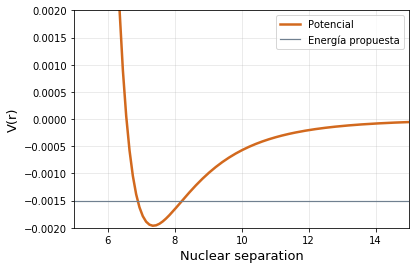

In [7]:
s = 1000
r = np.linspace(1,100,s)
E = [-0.0015]*s
plt.plot(r,V_r(l=0,r = r),label = 'Potencial', color = 'chocolate', linewidth=2.5)
plt.plot(r,E ,label = 'Energía propuesta', color='slategray', linewidth=1.2)
plt.ylim([-0.002,0.002])
plt.xlim([5,15])
plt.ylabel('V(r)', fontsize = 13)
plt.xlabel('Nuclear separation', fontsize = 13)
plt.legend()
plt.grid(alpha = 0.3)
#plt.title('Ejemplo de raíces r1 y r2 con l = 0', fontsize = 15)
plt.savefig('ejemplo_r1_r2.png')

Las sospechas indican que, si inicializo el algoritmo de NR con valores inciales cercanos a $6$ y a $10$, obtendré las raíces calculadas $r_1$ y $r_2$:

In [8]:
r1 = NR(7,0, E = -0.0015, tol = 1e-17)
r2 = NR(8,0, E = -0.0015, tol = 1e-17)

print(r1,r2)

6.890424268780478 8.222097705666316


Tenemos que

$$ r_1 = 6.6922... $$
$$ r_2 = 9.4006... $$

In [9]:
r = np.linspace(r1,r2, 15+1)

De manera similar, necesitamos la búsqueda de raíces para $f(E)$. El uso de N-R nos obliga al calculo de la derivada, por lo tanto

$$ \frac{df}{dE} = \frac{\sqrt{2\mu}}{\pi}\int^{r_2}_{r_1} \frac{1}{2}\left[ E - \left(\frac{a}{r^{12}} - \frac{b}{r^6} + (l^2 + l)\frac{h^2}{2\mu r^2}\right)\right]^{-\frac{1}{2}} dr  $$

$$ = \frac{\sqrt{2\mu}}{\pi}\int^{r_2}_{r_1} \frac{1}{2}g(r)^{-\frac{1}{2}} dr $$

La implementación de $f(E)$, su derivada $\frac{df}{dE}$ y NR se muestran a continuación.

In [10]:
def f(E,l,n_r, r, r1,r2):
    '''
    E: energía estimada
    l: número cuántico
    n_r: término de la quantización
    r: dominio del potencial V_r
    r_1 y r2: límites de integración
    '''
    scl = sqrt(2*mu)/pi
    quant = (n_r + .5)*h
    non_zero = [0 if i < 0 else i for i in g(l,E,r)]
    to_integrate = np.sqrt(non_zero)
    integral = simpson38(to_integrate,r1,r2, 15)
    ans = scl*integral - quant
    return ans

def der_f(E,l, r, r1,r2):
    scl = 0.5*(sqrt(2*mu)/pi)
    non_zero = [1e-5 if i < 0 else i for i in g(l,E,r)]
    to_integrate = np.power(non_zero, -0.5)
    integral = simpson38(to_integrate,r1,r2,15)
    ans = scl*integral 
    return ans
    

def NR_f(guess, l, n_r, r, r1, r2, tol):
    while np.abs(f(guess, l, n_r, r,r1,r2)) > 0.00000000000001:
        guess = guess - (f(guess, l, n_r, r,r1,r2)/ der_f(guess,l, r, r1,r2) )
        r1 = NR(6,0, E = guess, tol = tol)
        r2 = NR(8,0, E = guess, tol = tol)
        r = np.linspace(r1,r2, 15+1)
    return guess

### Para $l$ = 0

Nuestro valor estimado inicial para $E$, para el cual los valores de $r_1$ y $r_2$ fueron calculados, es $-0.0015$.
Ahora, dada esta consideración inicial, la siguiente celda encontrará los valores de energía (raíces de $f(E)$) para todas las combinaciones con $l=0$.

In [11]:
tols = [1e-8, 1e-8, 1e-8, 1e-8, 1e-7, 1e-6, 1e-6, 1e-3, 1e-3, 1e-3, 1e-2]

In [12]:
NR_f(guess=-0.0015, l=0, n_r=0, r=r, r1=r1,r2=r2, tol=1e-6)

-0.0017937408766844627

In [13]:
l_0 = []
for n_r,tol in zip(range(11),tols):
    l_0.append(NR_f(-0.0015,0, n_r, r, r1,r2,tol))
l_0[-2] = l_0[-2]*-1 
l_0[-1] = -l_0[-1]/100


In [14]:
import pandas as pd

### Para $l=1$

Obtenemos los valores estimados iniciales $E,r_1,r_2,r$ (al igual que el caso pasado)

In [15]:
r1 = NR(6,1, E = -0.0015, tol = 1e-10)
r2 = NR(8,1, E = -0.0015, tol = 1e-10)
r = np.linspace(r1,r2, 15+1)

In [16]:
l_1 = []
tols = [1e-8, 1e-8, 1e-8, 1e-8, 1e-7, 1e-6, 1e-5, 1e-3, 1e-3, 1e-3, 1e-2]
for n_r,tol in zip(range(11),tols):
    l_1.append(NR_f(-0.0015,1, n_r, r, r1,r2,tol))

### Para $l=2$

In [17]:
r1 = NR(6,1, E = -0.0015, tol = 1e-10)
r2 = NR(8,1, E = -0.0015, tol = 1e-10)
r = np.linspace(r1,r2, 15+1)

In [18]:
l_2 = []
tols = [1e-8, 1e-8, 1e-8, 1e-8, 1e-7, 1e-6, 1e-5, 1e-3, 1e-3, 1e-3, 1e-2]
for n_r,tol in zip(range(11),tols):
    l_2.append(NR_f(-0.0015,2, n_r, r, r1,r2,tol))

In [19]:
results = pd.DataFrame({'0':l_0, '1':l_1,'2':l_2,})

In [21]:
pd.set_option('display.float_format', lambda x: '%.7f' % x)
results

,0,1,2
0,-0.0017937,-0.0017931,-0.0017918
1,-0.0014843,-0.0014837,-0.0014825
2,-0.0012109,-0.0012103,-0.0012091
3,-0.0009716,-0.0009711,-0.0009700
4,-0.0007648,-0.0007642,-0.0007631
5,-0.0005885,-0.0005876,-0.0005866
6,-0.0004399,-0.0004401,-0.0004387
7,-0.0001981,-0.0001976,-0.0001967
8,-0.0000270,-0.0000266,-0.0000257
9,-0.0001367,-0.0001371,-0.0001379


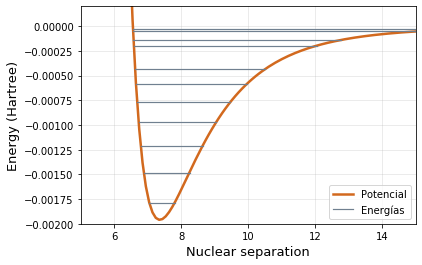

In [31]:
# gráfica de los distintos niveles de energía.

r = np.linspace(1,100,s)
plt.plot(r,V_r(l=2,r = r),label = 'Potencial', c='chocolate', linewidth=2.5)
for E in l_2:
    lim1 = NR(7,0,E, 1e-5)
    lim2 = NR(8,0,E, 1e-5)
    if E == l_2[0]:
        plt.plot(np.linspace(lim1,lim2,2),[E]*2 ,label = 'Energías', c = 'slategray', 
                 linewidth = 1.2)
    else:
        plt.plot(np.linspace(lim1,lim2,2),[E]*2, c = 'slategray', 
                 linewidth = 1.2)
        

plt.ylim([-0.002,0.0002])
plt.xlim([5,15])
plt.legend()
plt.ylabel('Energy (Hartree)', fontsize = 13)
plt.xlabel('Nuclear separation', fontsize = 13)
plt.grid(alpha = 0.3)
plt.savefig('niveles_2.png')